# Simplistic Analysis of COVID-19 Data

repo: https://github.com/markrichter14/COVID-19/blob/master/COVID-19.ipynb


In [1]:
import os
import shutil
import datetime as dt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#warnings.warn(msg, FutureWarning)

#########1#########2#########3#########4#########5#########6#########7#########

In [2]:
def format_num(n):
    if n >= 1e4:
        grp = np.log10(n) // 3
        ltr = {1:'K', 2:'M', 3:'B', 4:'T'}[grp]
        dgt = {0:0, 1:2, 2:1}[np.ceil(np.log10(n)) % 3]
        fmt = '{0:.' + str(dgt) + 'f}'
        return fmt.format(n / (1000 ** grp)) + ltr
    return str(int(n))

# tc = [
#     1234, 8234, 12345, 9876543, 12345678, 
#     526389, 526389456, 2526389456, 1e9+7
# ]

# for n in sorted(tc):
#     print(f'{n:<12}  {np.log10(n) // 3:.2f}  {np.log10(n) % 3:.2f}  ' + 
#           f'{format_num(n)}')


In [3]:
SPANISH = {
    'US': 'EE.UU.',
    'New Zealand': 'Nueva Zelanda',
    'Korea, South': 'Corea del Sur',
    'Spain': 'España',
    'Italy': 'Italia',
}

In [4]:
def exp_curve(x, a, b, c):
    return a * np.exp(b * x) + c

def log_curve(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

In [5]:
def curve_fit_coeffs(df, curve):
    '''
    Calculate curve fit of data and add to dataframe
    '''
    popt, pcov = curve_fit(curve, df['Day'], df['Cases'], p0=(1, 1e-6, 1))

    print(f'{df.country} data from {df.source}\n\n' + 
          f'popt:\n{popt}\n\npcov:\n{pcov}')
    
    df.popt = popt
    df.pcov = pcov
    
    return popt, pcov

In [6]:
#########1#########2#########3#########4#########5#########6#########7#########
def convert_data(data, meta, mm_days = 7):
    '''
    Generate df for manual entry
    '''
    cols = ['Date', 'Cases']
    df = pd.DataFrame(data, columns=cols)
    df['New'] = df['Cases'].diff()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day'] = (df['Date'] - df['Date'][0]).dt.days
    df.set_index('Date', inplace=True)

    df.country = meta['country']
    df.source = meta['source']
    
    return df

In [7]:
#########1#########2#########3#########4#########5#########6#########7#########
def filter_import(df_import, code):
    '''
    Filters and formats data imported from HDX
    Takes a dataframe containing all data, and a 3-letter code for country
    Return a formatted dataframe
    '''
    SRC = 'HDX'
    
    df = df_csv[df_csv['Code'] == code]
    country_name = df['Country'].values[0]
    df = df[df['Value'] != 0]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.groupby(['Date']).sum()
    df = df.sort_index()
    df = df.rename(columns={"Value": "Cases"})
    df['Day'] = (df.index - df.index[0]).days
    df['New'] = df['Cases'].diff()
    
    df.country = country_name
    df.source = SRC
    
    return df

---
## Infection Data

Data for Colombia as reported by El Tiempo

https://www.eltiempo.com/datos/coronavirus-en-colombia-casos-actualizados-y-confirmados-471650

In [8]:
# Colombian data from Instituto Nacional de Salud

data = [
    ['2020-03-06',    1], ['2020-03-07',    1], ['2020-03-08',    1],
    ['2020-03-09',    3], ['2020-03-10',    3], ['2020-03-11',    9],
    ['2020-03-12',   13], ['2020-03-13',   16], ['2020-03-14',   24],
    ['2020-03-15',   45], ['2020-03-16',   57], ['2020-03-17',   75],
    ['2020-03-18',  102], ['2020-03-19',  128], ['2020-03-20',  175],
    ['2020-03-21',  210], ['2020-03-22',  240], ['2020-03-23',  306],
    ['2020-03-24',  378], ['2020-03-25',  470], ['2020-03-26',  491],
    ['2020-03-27',  539], ['2020-03-28',  608], ['2020-03-29',  702],
    ['2020-03-30',  798], ['2020-03-31',  906], ['2020-04-01', 1065],
    ['2020-04-02', 1161], ['2020-04-03', 1267], ['2020-04-04', 1406],
    ['2020-04-05', 1485], ['2020-04-06', 1579], ['2020-04-07', 1780],
    ['2020-04-08', 2054], ['2020-04-09', 2223], ['2020-04-10', 2473],
    ['2020-04-11', 2709],
    ['2020-04-12', 2776],
    ['2020-04-13', 2852],
]

meta = {
    'country': 'Colombia',
    'source': 'INS',
}

df_infect = convert_data(data, meta)

df_infect.tail(7)

,Cases,New,Day
Date,,,
2020-04-07,1780,201.0,32
2020-04-08,2054,274.0,33
2020-04-09,2223,169.0,34
2020-04-10,2473,250.0,35
2020-04-11,2709,236.0,36
2020-04-12,2776,67.0,37
2020-04-13,2852,76.0,38


---

## Imports from Humanitarian Data Exchage (HDX)

Novel Coronavirus (COVID-19) Cases Data (JHU CSSE)

https://data.humdata.org/dataset/5dff64bc-a671-48da-aa87-2ca40d7abf02


In [9]:
fn = 'time_series_covid19_confirmed_global_narrow.csv'

df_csv = pd.read_csv(fn, 
                     usecols=['Date',
                              'Value', 
                              'ISO 3166-1 Alpha 3-Codes', 
                              'Country/Region'],
                     skiprows=[1])

df_csv = df_csv.rename(columns={'ISO 3166-1 Alpha 3-Codes': 'Code',
                                'Country/Region': 'Country'})

In [10]:
# Colombia

df_COL = filter_import(df_csv, 'COL')

In [11]:
# US

df_US = filter_import(df_csv, 'USA')

df_US.tail(7)

,Cases,Day,New
Date,,,
2020-04-07,396223,76,29556.0
2020-04-08,429052,77,32829.0
2020-04-09,461437,78,32385.0
2020-04-10,496535,79,35098.0
2020-04-11,526396,80,29861.0
2020-04-12,555313,81,28917.0
2020-04-13,580619,82,25306.0


In [12]:
# South Korean data from HDX

df_KOR = filter_import(df_csv, 'KOR')

In [13]:
# New Zealand

df_NZL = filter_import(df_csv, 'NZL')

In [14]:
# Spain

df_ESP = filter_import(df_csv, 'ESP')

In [15]:
# Italy

df_ITA = filter_import(df_csv, 'ITA')

In [16]:
# China

df_CHN = filter_import(df_csv, 'CHN')

In [17]:
#########1#########2#########3#########4#########5#########6#########7#########
def plot_projected(df_orig, forecast=7, curve=exp_curve):
    '''
    Plot cases and growth vs Date
    '''
    MIN_CASES = 50
    PERIOD = 5

    df = df_orig[df_orig['Cases'] >= MIN_CASES]
    
    fig, ax = plt.subplots(figsize=(15, 10))

    # original data
    ax.plot(df.index, df['Cases'], 'ks', label="Total de casos")
    ax.set_ylabel('Casos', fontsize=16)

    if forecast:
        if curve == exp_curve:
            popt, pcov = curve_fit(curve, df['Day'], df['Cases'], 
                                   p0=(1, 1e-6, 1))
            curve_name = ' (exponencial)'
        elif curve == log_curve:
            popt, pcov = curve_fit(curve, df['Day'], df['Cases'], 
                                   p0=(1, 1e-6, 1, 30))
            curve_name = ' (logístico)'
        else:
            popt, pcov = curve_fit(curve, df['Day'], df['Cases'])
            curve_name = ''

        # trendline
        ax.plot(df.index, curve(df['Day'], *popt), 'r-', 
                label="Curva ajustada")

        # forecast
        fc_x = np.linspace(df['Day'][-1], 
                           df['Day'][-1] + forecast, 
                           forecast + 1)
        fc_dates = pd.date_range(df.index[-1], 
                                 df.index[-1] 
                                 + pd.to_timedelta(forecast, unit='d'))
        ax.plot(fc_dates, curve(fc_x, *popt), 'b*-', label="Pronóstico")

    ax.legend()
    
    # Growth
    ax2 = ax.twinx()
    new_period = df['Cases'].diff(PERIOD)
    growth = new_period.pct_change() + 1
    growth_avg = growth.rolling(PERIOD, min_periods=PERIOD).mean()

    ax2.plot(growth.index, growth, 'g^-', lw=0.2)
    ax2.plot(growth_avg.index, growth_avg, 'g--', lw=3)

    ax2.set_ylabel('Tasa de Crecimiento', fontsize=16, c='g')
    ax2.tick_params(axis='y', colors='g')
    # '1.0' growth line
    ax2.axhline(y=1.0, ls=':', c='g')
    
    ax.set_xlabel('Fecha', fontsize=16)
    title_str = f'Casos de Coronavirus'

    try:
        country = SPANISH.get(df_orig.country, df_orig.country)
        source = SPANISH.get(df_orig.source, df_orig.source)
        title_str += f' en {country} (fuente: {source})'
        if forecast:
            title_str += f'\nproyectados {forecast} dias' + curve_name
    except:
        pass

    ax.set_title(title_str, fontsize=20)
    ax.grid()

    fig.autofmt_xdate()
    # ax.yaxis.set_minor_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(7))

    # last growth data labels
    last_val = growth_avg[-1]
    ax2.annotate(
        f'{last_val:0.2f}', xy=(df.index[-1], last_val), ha='left', 
        va='bottom', xytext=(5, 1), textcoords="offset points", c='g',
    )

    # last actual data labels
    last_val = df['Cases'][-1]
    ax.annotate(
        format_num(last_val), xy=(df.index[-1], last_val), ha='left', va='top', 
        xytext=(0, 0), textcoords="offset points", rotation=-30, c='k',
    )

    # projection labels
    if forecast:
        for i, yi in enumerate(curve(fc_x[1:], *popt)):
            xi = fc_dates[1:][i]
            ax.annotate(
                format_num(yi), xy=(xi, yi), ha='left', va='top', 
                xytext=(0, 0), textcoords="offset points", rotation=-30, 
                c='b',
            )

    plt.show()

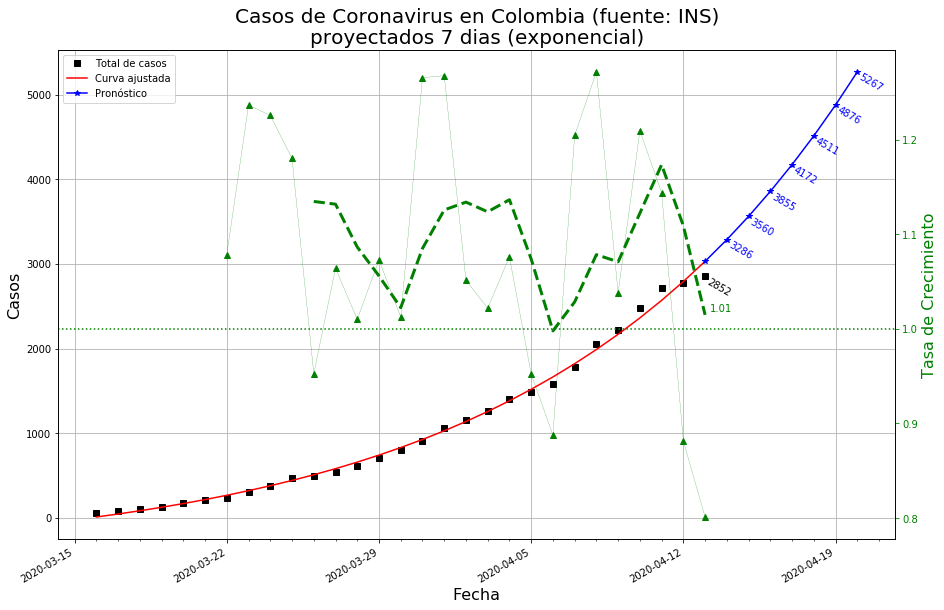

In [18]:
plot_projected(df_infect)

__Mi humilde interpretación:__ Colombia sigue mostrando un crecimiento exponencial de nuevos casos.  La tasa de crecimiento sigue siendo alta y no muestra el declive constante de otros países.

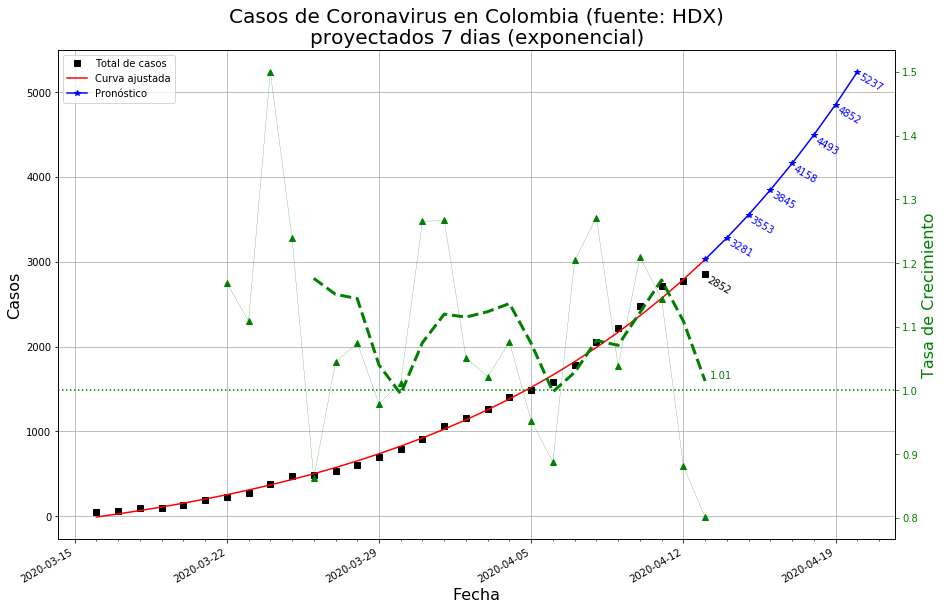

In [19]:
plot_projected(df_COL)

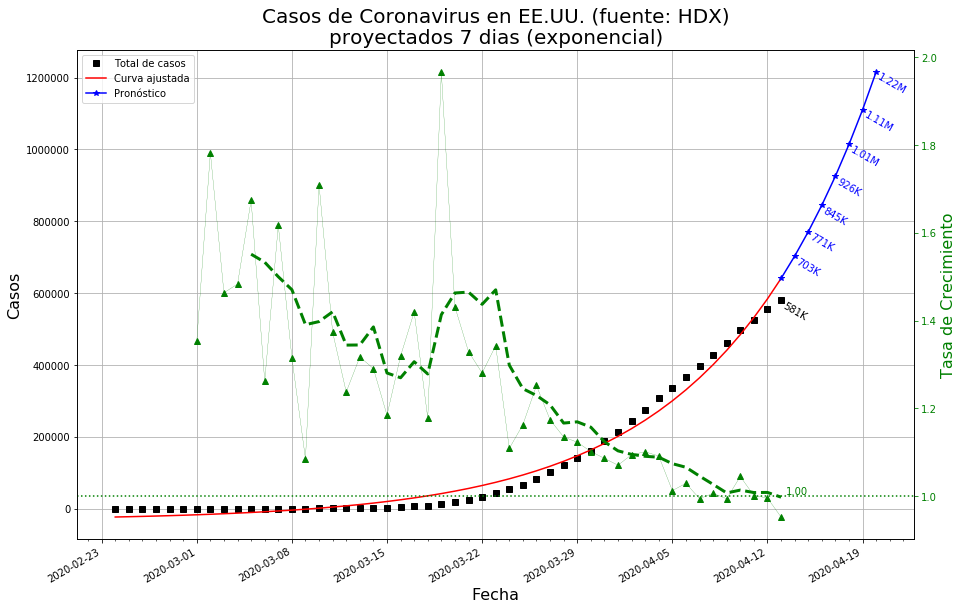

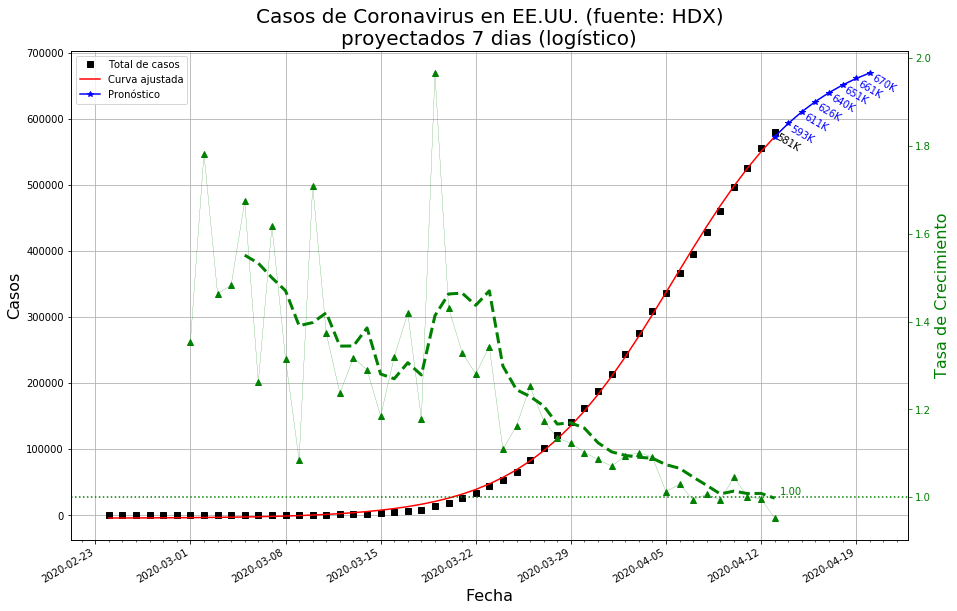

In [20]:
plot_projected(df_US)

plot_projected(df_US, curve=log_curve)

__Mi humilde interpretación:__ Los Estados Unidos siguen teniendo un alto número de nuevos casos y han sido noticia por establecer el récord de muertes, pero la tasa de crecimiento ha disminuido a 1,0, lo que indica un posible punto de infección y el fin del crecimiento exponencial de los casos.  Los datos están empezando a alejarse de la curva exponencial y se acercan más a la "S" de la curva logística.

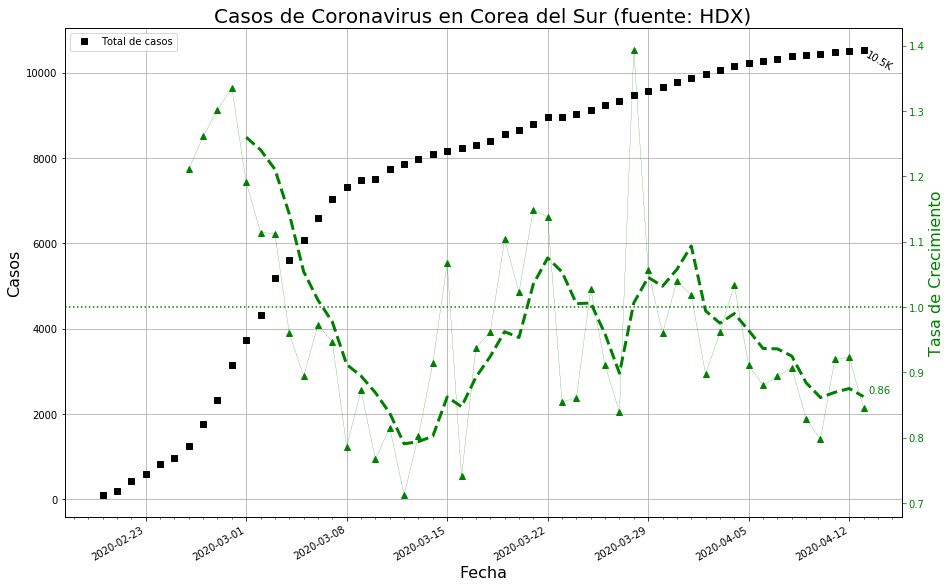

In [21]:
plot_projected(df_KOR, 0)

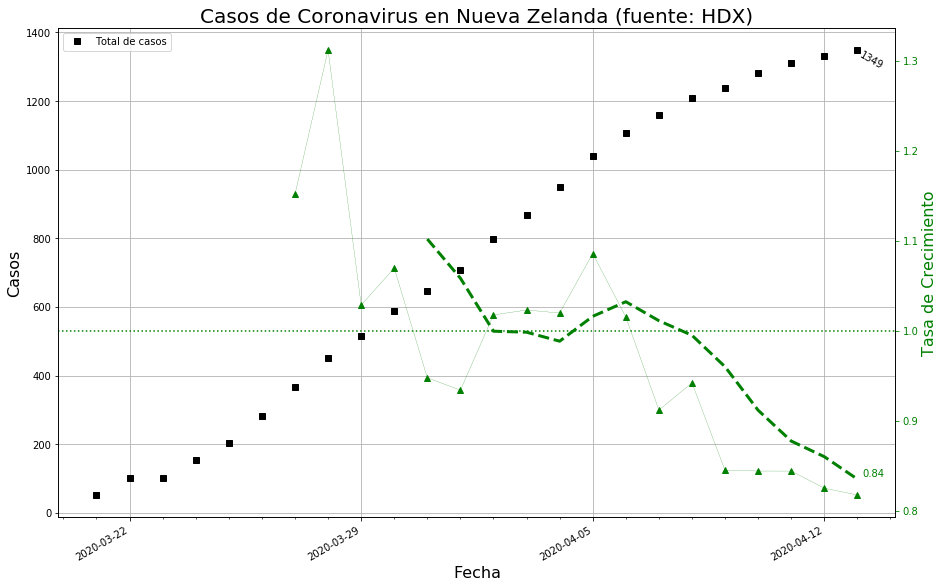

In [22]:
plot_projected(df_NZL, 0)

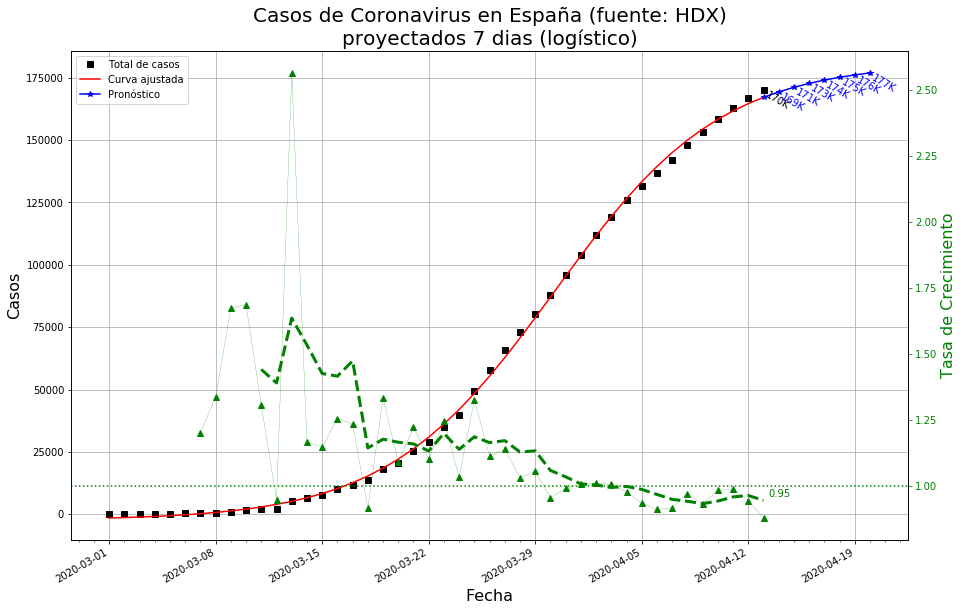

In [23]:
plot_projected(df_ESP, curve=log_curve)

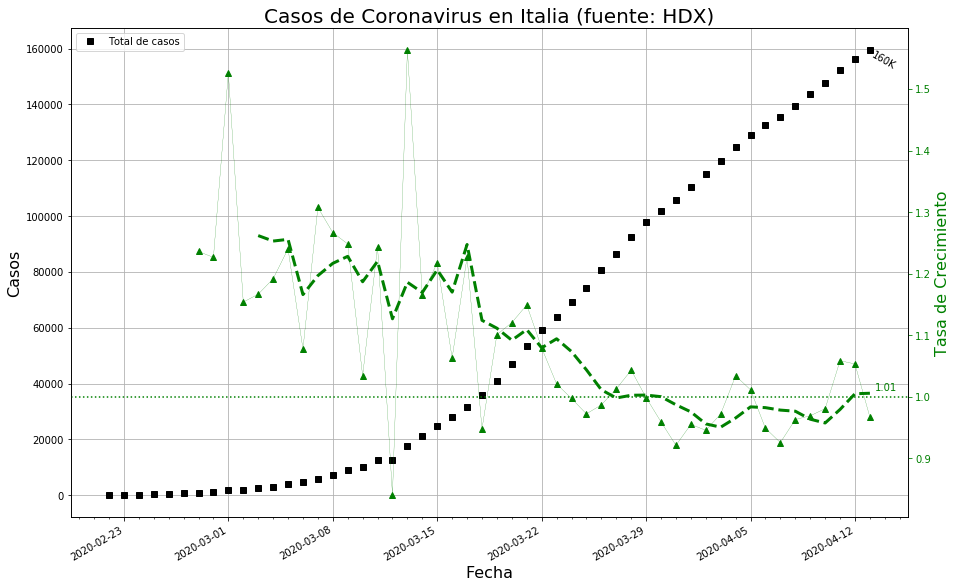

In [24]:
plot_projected(df_ITA, 0)

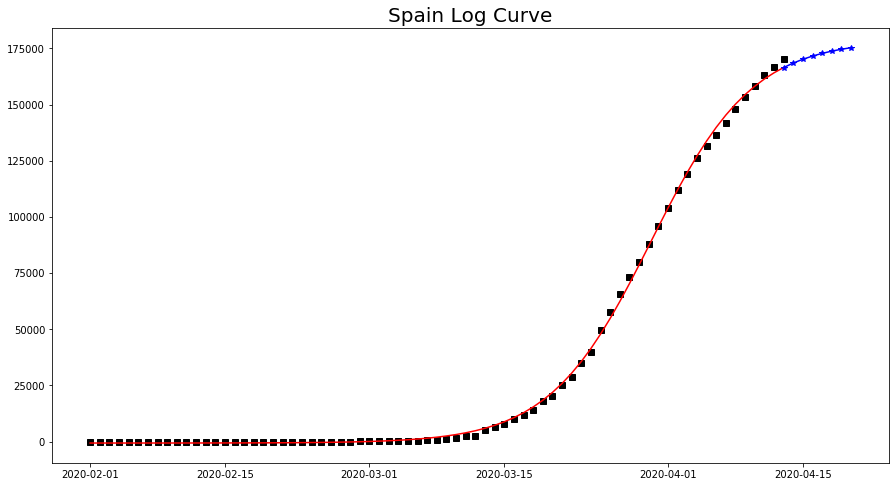

In [36]:
'''
Experiment with fitting logistic curve
'''
popt, pcov = curve_fit(log_curve, df_ESP['Day'], df_ESP['Cases'], p0=(1, 1e-6, 1, 30))
forecast = 7
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(df_ESP.index, df_ESP['Cases'], 'ks', label="Total de casos")
ax.plot(df_ESP.index, log_curve(df_ESP['Day'], *popt), 'r-', label="Curva ajustada")
fc_x = np.linspace(df_ESP['Day'][-1], 
                   df_ESP['Day'][-1] + forecast,
                   forecast + 1)
fc_dates = pd.date_range(df_ESP.index[-1], 
                         df_ESP.index[-1] + pd.to_timedelta(forecast, unit='d'))
ax.plot(fc_dates, log_curve(fc_x, *popt), 'b*-', label="Pronóstico")

ax.set_title('Spain Log Curve', fontsize=20)

plt.show()

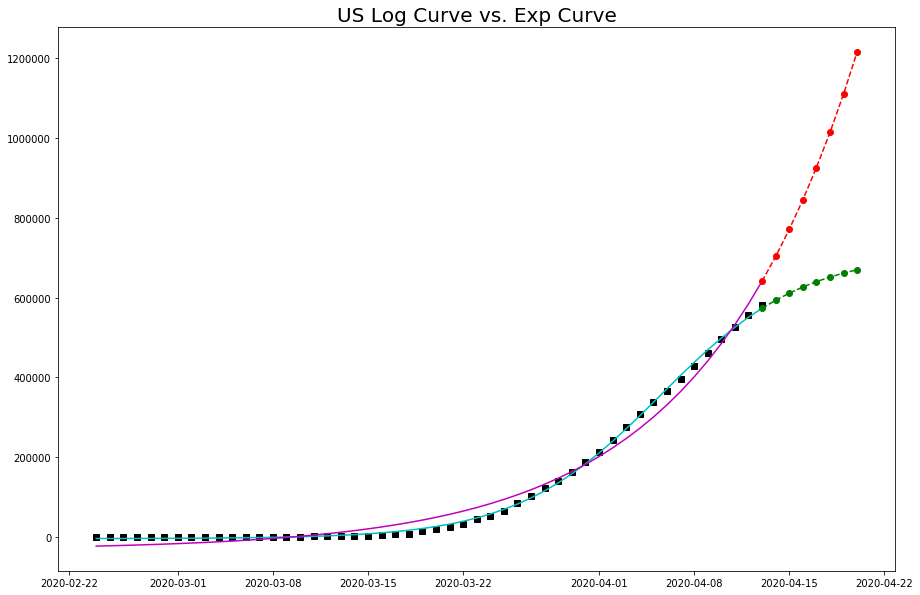

In [26]:
'''
Experiment with fitting and comparing logistic curve and exponential curve
'''
MIN_CASES = 50
df = df_US[df_US['Cases'] >= MIN_CASES]

popt, pcov = curve_fit(log_curve, df['Day'], df['Cases'], p0=(1, 1e-6, 1, 30))
forecast = 7
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(df.index, df['Cases'], 'ks', label="Total de casos")
ax.plot(df.index, log_curve(df['Day'], *popt), 'c-', label="Curva ajustada")
fc_x = np.linspace(df['Day'][-1], 
                   df['Day'][-1] + forecast,
                   forecast + 1)
fc_dates = pd.date_range(df.index[-1], 
                         df.index[-1] + pd.to_timedelta(forecast, unit='d'))
ax.plot(fc_dates, log_curve(fc_x, *popt), 'go--', label="Pronóstico")

popt, pcov = curve_fit(exp_curve, df['Day'], df['Cases'], p0=(1, 1e-6, 1))
ax.plot(df.index, exp_curve(df['Day'], *popt), 'm-', label="Curva ajustada")
fc_x = np.linspace(df['Day'][-1], 
                   df['Day'][-1] + forecast,
                   forecast + 1)
fc_dates = pd.date_range(df.index[-1], 
                         df.index[-1] + pd.to_timedelta(forecast, unit='d'))
ax.plot(fc_dates, exp_curve(fc_x, *popt), 'ro--', label="Pronóstico")

ax.set_title('US Log Curve vs. Exp Curve', fontsize=20)

plt.show()

In [27]:
#########1#########2#########3#########4#########5#########6#########7#########
def plot_log_log(dfs):
    '''
    Plot New Cases vs Total Cases
    '''
    MIN_CASES = 60
    
    fig, ax = plt.subplots(figsize=(15, 8))

    # original data
    for df in dfs:
        country = SPANISH.get(df.country, df.country)
        df_min = df[df['Cases'] >= MIN_CASES]
        ax.loglog(df_min['Cases'], df_min['New'].rolling(7).sum(), '.-', 
                  label=country)
    ax.set_ylabel('Nuevos casos en los siete días anteriores\n(Logarítmico)',
                  fontsize=16)

    ax.legend(fontsize=14)

    ax.set_xlabel('Total de casos (logarítmico)', fontsize=16)
    ax.set_title(f'Trayectoria de los casos',
                 fontsize=24)
    ax.grid()

    plt.show()

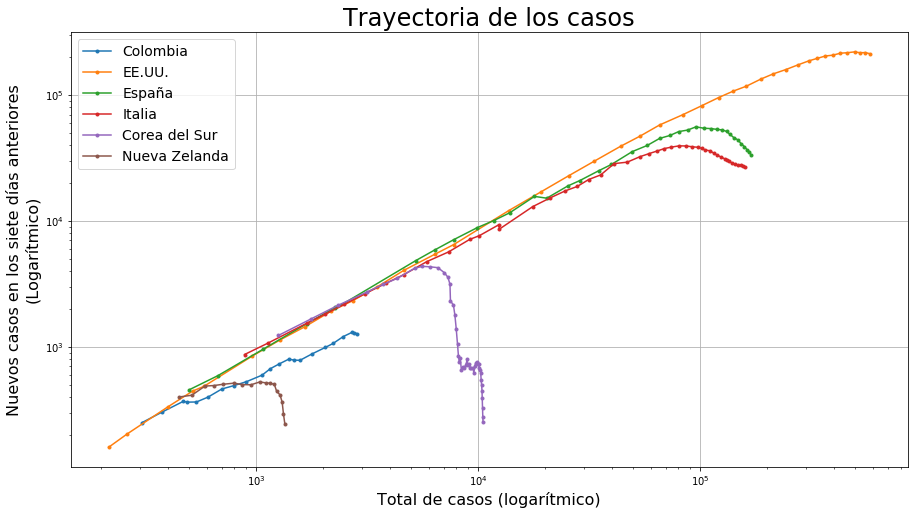

In [28]:
plot_log_log([df_infect, df_US, df_ESP, df_ITA, df_KOR, df_NZL])

__Mi humilde interpretación:__  Trazar el número de casos nuevos frente al total de casos de forma logarítmica permite ver el crecimiento exponencial como un movimiento hacia arriba y hacia la derecha.  Los países que controlan las nuevas infecciones muestran una tendencia más descendente.  

En este caso, la tendencia de Corea del Sur y, más recientemente, de Nueva Zelanda, se está moviendo más directamente hacia abajo con muy pocos casos nuevos.  España e Italia están claramente haciendo la transición a menos casos nuevos y es posible que EE.UU. haga lo mismo.  Colombia ha mostrado algunas pausas en la tasa de crecimiento, pero actualmente se encuentra en un crecimiento exponencial.
 
Los nuevos casos se suman en los últimos siete días para suavizar las variaciones diarias de los datos.

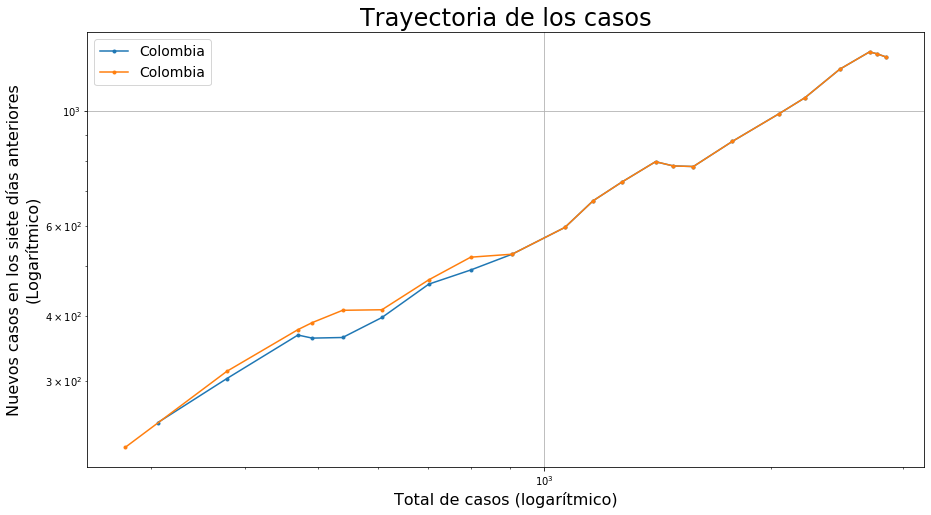

In [29]:
plot_log_log([df_infect, df_COL])

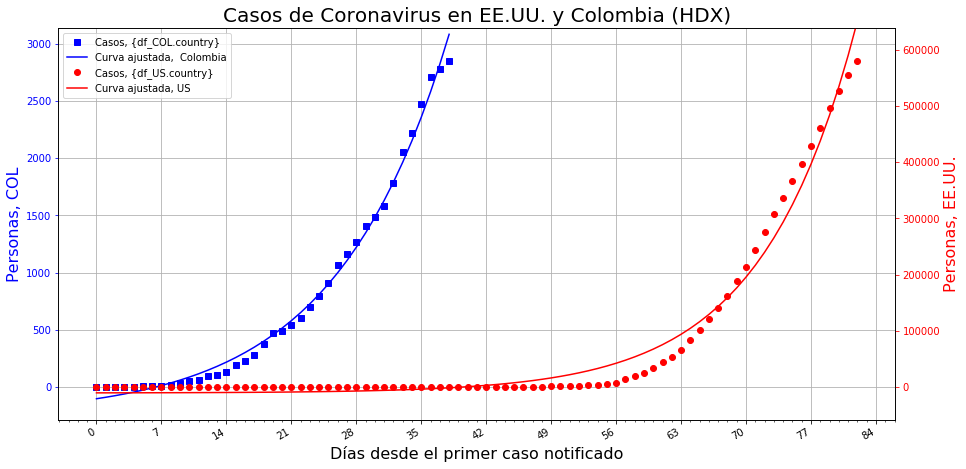

In [30]:
'''
Plot Cases vs Number of Days
'''
fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()

popt_US, pcov_US = curve_fit(exp_curve, df_US['Day'], df_US['Cases'], p0=(1, 1e-6, 1))
popt_COL, pcov_COL = curve_fit(exp_curve, df_COL['Day'], df_COL['Cases'], p0=(1, 1e-6, 1))

# trendline
ax2.plot(df_US['Day'], exp_curve(df_US['Day'], *popt_US), 'r-', 
         label=f"Curva ajustada, {df_US.country}")
ax.plot(df_COL['Day'], exp_curve(df_COL['Day'], *popt_COL), 'b-', 
        label=f"Curva ajustada,  {df_COL.country}")

# original data
ax2.plot(df_US['Day'], df_US['Cases'], 'ro', label="Casos, {df_US.country}")
ax2.set_ylabel('Personas, EE.UU.', c='r', fontsize=16)
ax2.tick_params(axis='y', colors='r')

ax.plot(df_COL['Day'], df_COL['Cases'], 'bs', label="Casos, {df_COL.country}")
ax.set_ylabel('Personas, COL', c='b', fontsize=16)
ax.tick_params(axis='y', colors='b')

# Hack limits for y axes
max_US = df_US['Cases'].max()
max_COL = df_COL['Cases'].max()
ax.set_ylim([max_COL * -0.1, max_COL * 1.1])
ax2.set_ylim([max_US * -0.1, max_US * 1.1])

# Legend (Combined, Reordered)
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(reversed(handles2 + handles), reversed(labels2 + labels))

ax.set_xlabel('Días desde el primer caso notificado', fontsize=16)
ax.set_title('Casos de Coronavirus en EE.UU. y Colombia (HDX)', fontsize=20)
ax.grid()

fig.autofmt_xdate()
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(7))

plt.show()

In [31]:
#########1#########2#########3#########4#########5#########6#########7#########
def compare_dfs(df_A, df_B, num_days=None):
    '''
    Compare Cases from two countries
    '''
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax2 = ax1.twinx()

    co_A = SPANISH.get(df_A.country, df_A.country)
    co_B = SPANISH.get(df_B.country, df_B.country)

    # limit US data to same number as Colombia
    pts = min(len(df_A), len(df_B))
    if num_days and pts - num_days > 0:
        df_A = df_A[-pts:num_days - pts]
        df_B = df_B[-pts:num_days - pts]
    else:
        df_A = df_A[-pts:]
        df_B = df_B[-pts:]

    popt_A, pcov_A = curve_fit(exp_curve, df_A['Day'], df_A['Cases'],
                               p0=(1, 1e-6, 1))
    popt_B, pcov_B = curve_fit(exp_curve, df_B['Day'], df_B['Cases'], 
                               p0=(1, 1e-6, 1))

    # original data
    ax1.plot(df_A.index, df_A['Cases'], 'r^', label=f'Casos, {co_A}')
    ax1.set_ylabel(f'Casos, {co_A}', c='r', fontsize=16)
    ax1.tick_params(axis='y', colors='r')

    ax2.plot(df_B.index, df_B['Cases'], 'bv', label=f'Casos, {co_B}')
    ax2.set_ylabel(f'Casos, {co_B}', c='b', fontsize=16)
    ax2.tick_params(axis='y', colors='b')

    # trendline
    ax1.plot(df_A.index, exp_curve(df_A['Day'], *popt_A), 'r-', 
             label=f"Curva ajustada, {co_A}")
    ax2.plot(df_B.index, exp_curve(df_B['Day'], *popt_B), 'b-', 
            label=f"Curva ajustada,  {co_B}")

    # Match limits for y axes
    max_A = df_A['Cases'].max()
    max_B = df_B['Cases'].max()
    ax1.set_ylim([max_A * -0.1, max_A * 1.1])
    ax2.set_ylim([max_B * -0.1, max_B * 1.1])

    # Legend (Combined, Reordered)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2)

    ax1.set_xlabel('Fecha', fontsize=16)
    date_fmt = '%-d/%-m/%y'
    dates = [df_A.index[0].strftime(date_fmt), df_A.index[-1].strftime(date_fmt)]
    ax1.set_title(f'Comparación del número de casos de COVID-19\n' 
                  + f'{co_A} y {co_B}, de {dates[0]} a {dates[1]}', fontsize=20)
    ax1.grid()

    fig.autofmt_xdate()
    # ax.yaxis.set_minor_locator(MultipleLocator(100))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.xaxis.set_major_locator(MultipleLocator(7))

    plt.show()

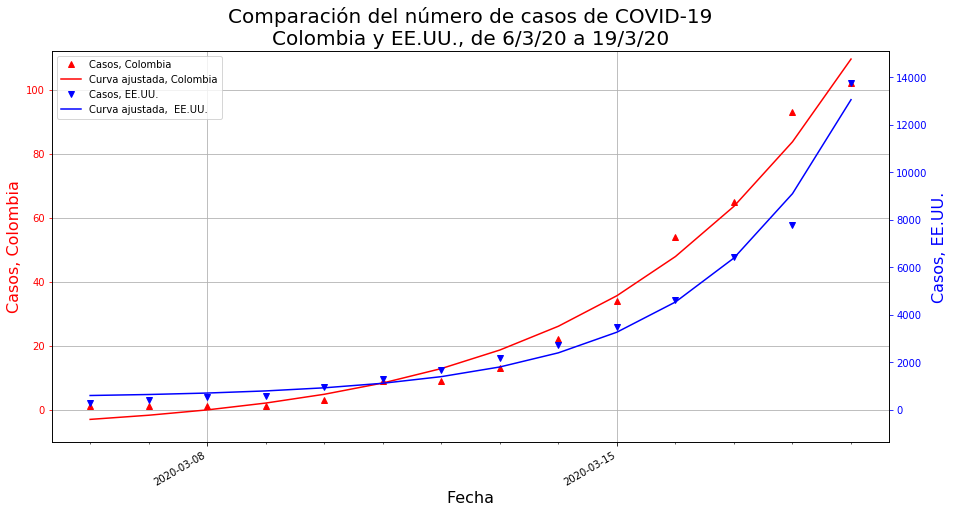

In [32]:
compare_dfs(df_COL, df_US, 14)

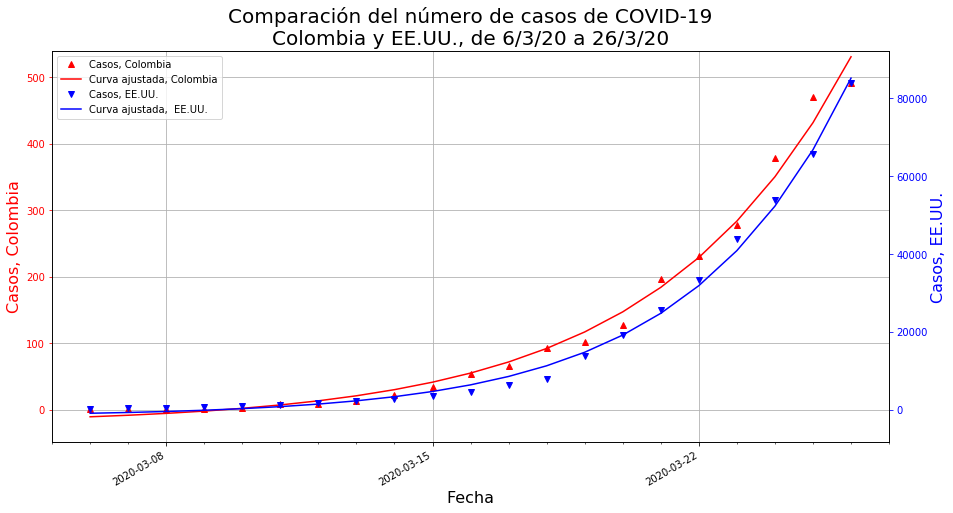

In [33]:
compare_dfs(df_COL, df_US, 21)

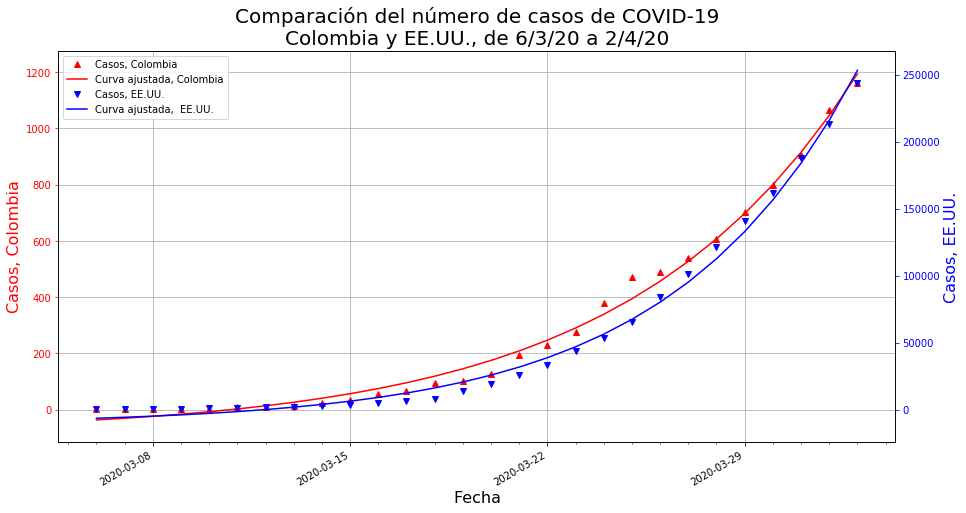

In [34]:
compare_dfs(df_COL, df_US, 28)

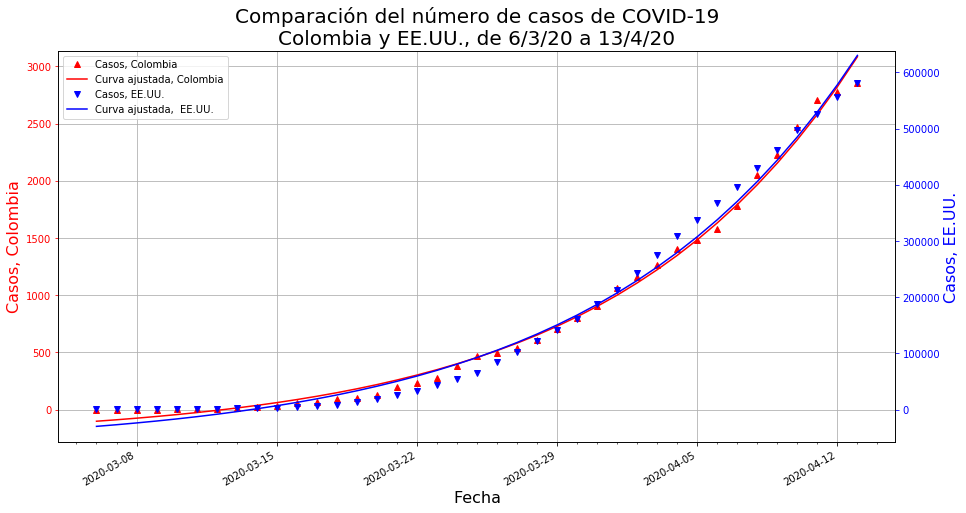

In [35]:
compare_dfs(df_COL, df_US)